## Importing Packages

In [36]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [37]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_eng = stopwords.words("english") + list(punctuation)

## Importing Data

In [38]:
df = pd.read_csv('data/Restaurant reviews.csv')

In [39]:
df

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0
...,...,...,...,...,...,...,...
9995,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3,"53 Reviews , 54 Followers",6/5/2016 0:08,0
9996,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0
9997,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3
9998,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4,"13 Reviews , 144 Followers",5/31/2016 17:22,0


In [40]:
df.drop(columns=['Time','Pictures','Reviewer','Restaurant','Metadata'],inplace=True)

In [41]:
df

,Review,Rating
0,"The ambience was good, food was quite good . h...",5
1,Ambience is too good for a pleasant evening. S...,5
2,A must try.. great food great ambience. Thnx f...,5
3,Soumen das and Arun was a great guy. Only beca...,5
4,Food is good.we ordered Kodi drumsticks and ba...,5
...,...,...
9995,Madhumathi Mahajan Well to start with nice cou...,3
9996,This place has never disappointed us.. The foo...,4.5
9997,"Bad rating is mainly because of ""Chicken Bone ...",1.5
9998,I personally love and prefer Chinese Food. Had...,4


In [42]:
df.Rating.value_counts()

5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64

In [43]:
df.Rating=df.Rating.replace('Like',5)
df.Rating=df.Rating.astype('float')

In [44]:
df

,Review,Rating
0,"The ambience was good, food was quite good . h...",5.0
1,Ambience is too good for a pleasant evening. S...,5.0
2,A must try.. great food great ambience. Thnx f...,5.0
3,Soumen das and Arun was a great guy. Only beca...,5.0
4,Food is good.we ordered Kodi drumsticks and ba...,5.0
...,...,...
9995,Madhumathi Mahajan Well to start with nice cou...,3.0
9996,This place has never disappointed us.. The foo...,4.5
9997,"Bad rating is mainly because of ""Chicken Bone ...",1.5
9998,I personally love and prefer Chinese Food. Had...,4.0


In [45]:
df.isnull().sum()

Review    45
Rating    38
dtype: int64

In [46]:
df.dropna(inplace=True)

In [47]:
df.Rating.value_counts()

5.0    3827
4.0    2373
1.0    1735
3.0    1192
2.0     684
4.5      69
3.5      47
2.5      19
1.5       9
Name: Rating, dtype: int64

In [48]:
df.Rating = np.where(df.Rating < 3.5,0,1)

In [49]:
df

,Review,Rating
0,"The ambience was good, food was quite good . h...",1
1,Ambience is too good for a pleasant evening. S...,1
2,A must try.. great food great ambience. Thnx f...,1
3,Soumen das and Arun was a great guy. Only beca...,1
4,Food is good.we ordered Kodi drumsticks and ba...,1
...,...,...
9995,Madhumathi Mahajan Well to start with nice cou...,0
9996,This place has never disappointed us.. The foo...,1
9997,"Bad rating is mainly because of ""Chicken Bone ...",0
9998,I personally love and prefer Chinese Food. Had...,1


## Dataset Splitting

In [50]:
X = df.Review
y = df.Rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7964,), (1991,), (7964,), (1991,))

## Training

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

from sklearn.feature_extraction.text import CountVectorizer

pipeline = Pipeline([
    ('prep', CountVectorizer(tokenizer = word_tokenize, stop_words=sw_eng)),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=5, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  8.3min finished
C:\Users\Ferdian\miniconda3\envs\jcop_wv\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


{'algo__C': 0.09104259182413332, 'algo__fit_intercept': False}
0.9178804620793571 0.8650174128647002 0.8799598191863385


## Evalution

In [52]:
from jcopml.plot import plot_confusion_matrix

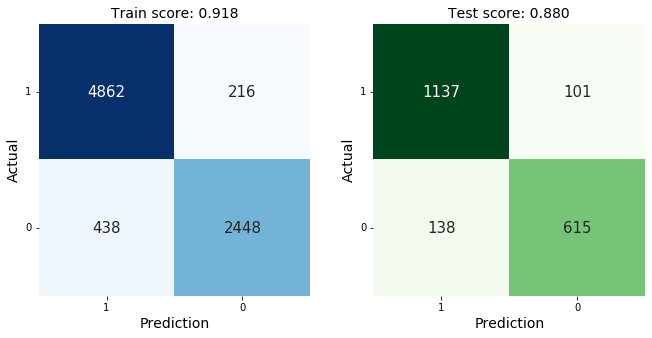

In [53]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

## Prediction

In [54]:
X_pred = [" The food is fucking awesome"]

In [55]:
model.predict(X_pred)

array([1])